In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

from dataset import CelebADataset
from models.wgan import (
    Discriminator,
    Generator,
    WGAN
)
from utils import display_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


# 0. Parameters

In [4]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 32
Z_DIM = 200
EPOCHS = 10
LR = 1e-4
LOAD_MODEL = False

# 1. Prepare the data

In [5]:
data_path = '../celeba/'

data = CelebADataset(data_path=data_path,
                     batch_size=BATCH_SIZE,
                     num_workers=16,
                     pin_memory=True)
# Uncomment if you haven't downloaded the dataset.
# data.prepare_data()
data.setup()

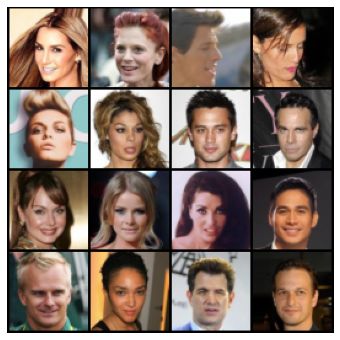

In [6]:
data_head = torch.stack([data.celeba_train[i][0] for i in range(16)])
display_grid(data_head, nrow=4, figsize=(6, 6))

# 2. Build WGAN

## Generator

In [7]:
g = Generator(channels=3, latent_dim=200)

In [8]:
summary(g, (100, 200))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [100, 3, 64, 64]          --
├─Sequential: 1-1                        [100, 12]                 --
│    └─Linear: 2-1                       [100, 12]                 2,412
│    └─ReLU: 2-2                         [100, 12]                 --
├─Sequential: 1-2                        [100, 3, 64, 64]          --
│    └─Sequential: 2-3                   [100, 512, 4, 4]          --
│    │    └─ConvTranspose2d: 3-1         [100, 512, 4, 4]          14,336
│    │    └─BatchNorm2d: 3-2             [100, 512, 4, 4]          1,024
│    │    └─LeakyReLU: 3-3               [100, 512, 4, 4]          --
│    └─Sequential: 2-4                   [100, 256, 8, 8]          --
│    │    └─ConvTranspose2d: 3-4         [100, 256, 8, 8]          1,179,904
│    │    └─BatchNorm2d: 3-5             [100, 256, 8, 8]          512
│    │    └─LeakyReLU: 3-6               [100, 256, 8, 8]          

## Discriminator

In [9]:
d = Discriminator(channels=3)

In [10]:
summary(d, (1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1, 2, 2]              --
│    └─Sequential: 2-1                   [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 32, 32, 32]           896
│    │    └─LeakyReLU: 3-2               [1, 32, 32, 32]           --
│    └─Sequential: 2-2                   [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-3                  [1, 64, 16, 16]           18,496
│    │    └─LeakyReLU: 3-4               [1, 64, 16, 16]           --
│    └─Sequential: 2-3                   [1, 128, 8, 8]            --
│    │    └─Conv2d: 3-5                  [1, 128, 8, 8]            73,856
│    │    └─LeakyReLU: 3-6               [1, 128, 8, 8]            --
│    └─Sequential: 2-4                   [1, 256, 4, 4]            --
│    │    └─Conv2d: 3-7                  [1, 256, 4, 4]            295,168
│